# Evaluating Models with COCO Scoring

This example notebook demonstrates how to use the `COCOScorer` class to generate detection scores using the `COCO` and `COCOEval` APIs. For this notebook, we use a sample test image and [COCO-format](https://cocodataset.org/#format-data) annotation file from the [VisDrone](https://github.com/VisDrone/VisDrone-Dataset) dataset.

## Table of Contents
* [Set Up the Environment](#environment-setup)
* [Select Sample Input Image and Detections](#sample-input-image-and-detections)
* [Format and Display Ground-Truth (GT) Detections](#format-and-display-gt-detections)
* [Load the Model](#load-the-model)
* [Visualize Predicted Detections](#visualize-predicted-detections)
* [Generate Scores](#generate-scores)

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kitware/nrtk/blob/main/docs/examples/coco_scorer.ipynb)

## Set Up the Environment <a name="environment-setup"></a>

**Note for Colab users**: After setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](./README.md) for more info).

Note: We are suppressing warnings within this notebook to reduce visual clutter for demonstration purposes. If any issues arise while executing this notebook, we recommend that this cell is **not** executed so that any related warnings are shown. 

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
import sys  # noqa: F401

!{sys.executable} -m pip install -qU pip
print("Installing nrtk...")
!{sys.executable} -m pip install -q nrtk
print("Installing torch and torchvision...")
!{sys.executable} -m pip install -q "torch!=2.0.1" torchvision
print("Installing smqtk-detection CenterNet model (pretrained on the VisDrone dataset) ")
!{sys.executable} -m pip install -qU smqtk-detection[centernet]
print("Installing headless OpenCV...")
!{sys.executable} -m pip uninstall -qy opencv-python opencv-python-headless  # make sure they're both gone.
!{sys.executable} -m pip install -q opencv-python-headless
print("Done!")

Installing torch and torchvision...
Installing smqtk-detection CenterNet model (pretrained on the VisDrone dataset) 
Done!


## Select Sample Input Image and Detections <a name="sample-input-image-and-detections"></a>

For this notebook, we use a sample test image and COCO-format annotation file from the VisDrone dataset.

In [2]:
import json
import os
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from PIL import Image
from smqtk_image_io.bbox import AxisAlignedBoundingBox

data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

url = "https://data.kitware.com/api/v1/item/623880f14acac99f429fe3ca/download"

img_path = os.path.join(data_dir, "visdrone_img.jpg")
if not os.path.isfile(img_path):
    _ = urllib.request.urlretrieve(url, img_path)  # noqa: S310
img = np.asarray(Image.open(img_path))

json_url = "https://data.kitware.com/api/v1/item/6596fde99c30d6f4e17c9eff/download"

with urllib.request.urlopen(json_url) as gt_data:  # noqa: S310
    gt = json.loads(gt_data.read().decode())

json_filename = "sample.json"
with open(os.path.join(data_dir, json_filename), "w") as f:
    json.dump(gt, f)

## Format and Display Ground-Truth (GT) Detections <a name="format-and-display-gt-detections"></a>

We convert the COCO annotations to the SMQTK format to make them compatible with the model and the scorer implementations.

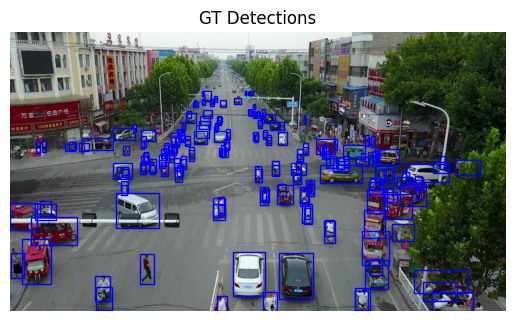

In [ ]:
from typing import Any


def format_detections(ann: dict[str, Any]) -> tuple[AxisAlignedBoundingBox, dict[str, Any]]:
    """Format detections in smqtk-detection format."""
    min_x, min_y, w, h = ann["bbox"]
    cat_id = ann["category_id"]
    img_id = ann["image_id"]
    return (AxisAlignedBoundingBox((min_x, min_y), (min_x + w, min_y + h)), {"category_id": cat_id, "image_id": img_id})


gt_smqtk_format = []
for i in gt["annotations"]:
    formatted_gt = format_detections(i)
    gt_smqtk_format.append(formatted_gt)

fig, ax = plt.subplots()
ax.set_title("GT Detections")
ax.imshow(img)
ax.set_axis_off()
for gt_data in gt_smqtk_format:
    bbox = gt_data[0]
    width = bbox.max_vertex[0] - bbox.min_vertex[0]
    height = bbox.max_vertex[1] - bbox.min_vertex[1]

    ax.add_patch(
        Rectangle(
            (bbox.min_vertex[0], bbox.min_vertex[1]),
            width,
            height,
            linewidth=1,
            edgecolor="b",
            facecolor="none",
        ),
    )
plt.show()

## Load the Model <a name="load-the-model"></a>

We generate detections using SMQTK's custom `CenterNetVisdrone` model with `Resnet-50` weights pretrained with the VisDrone dataset.

In [4]:
from smqtk_detection.impls.detect_image_objects.centernet import CenterNetVisdrone

model_file = os.path.join(data_dir, "centernet-resnet50.pth")
if not os.path.isfile(model_file):
    urllib.request.urlretrieve("https://data.kitware.com/api/v1/item/623259f64acac99f426f21db/download", model_file)

center_net_detector = CenterNetVisdrone(
    arch="resnet50",
    model_file="data/centernet-resnet50.pth",
    max_dets=500,
    use_cuda=False,
    batch_size=1,
    num_workers=1,
)

dets = list(list(center_net_detector([img]))[0])

## Visualize Predicted Detections <a name="visualize-predicted-detections"></a>

Here we visualize the detections for the test image from the `CenterNetVisdrone` model.

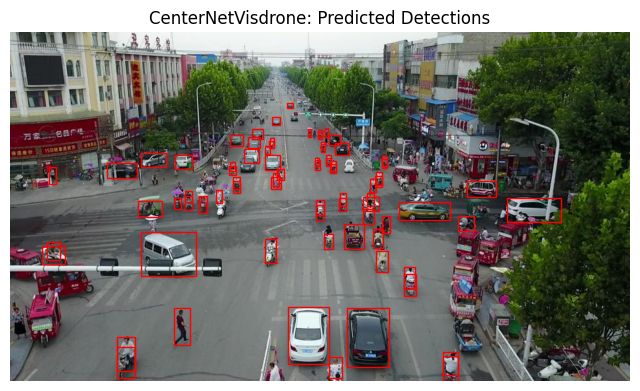

In [ ]:
from collections.abc import Hashable

from matplotlib.axes import Axes


def show_dets(
    ax: Axes,
    dets: list[tuple[AxisAlignedBoundingBox, dict[Hashable, float]]],
    thresh: float = 0.5,
) -> None:
    """Show detections with confidence over ``thres`` on given axes."""
    for det in dets:
        score_dict = det[1]
        cls_name = max(score_dict, key=lambda key: score_dict[key])
        conf = score_dict[cls_name]

        if conf >= thresh:
            bbox = det[0]
            x_1, y_1 = bbox.min_vertex
            x_2, y_2 = bbox.max_vertex

            ax.add_patch(
                Rectangle(
                    (x_1, y_1),
                    x_2 - x_1,
                    y_2 - y_1,
                    linewidth=1,
                    edgecolor="r",
                    facecolor="none",
                ),
            )


fig, axs = plt.subplots(figsize=(8, 8))
axs.set_title("CenterNetVisdrone: Predicted Detections")
axs.imshow(img)
axs.axis("off")
show_dets(axs, dets, thresh=0.4)

## Generate Scores <a name="generate-scores"></a>

We test the `COCOScorer` implementation by generating scores for the original predictions and with a slightly perturbed version of the predictions.

In [6]:
from nrtk.impls.score_detections.coco_scorer import COCOScorer

scorer = COCOScorer(gt_path=os.path.join(data_dir, json_filename), stat_index=0)
print(f"Categories list: {scorer.cat_ids}")

scores_list = scorer(actual=[gt_smqtk_format], predicted=[dets])
print(f"Final COCO Eval score: {scores_list[0]}")

perturbed_dets = []
for bbox, scores in dets:
    x_1, y_1 = bbox.min_vertex
    x_2, y_2 = bbox.max_vertex
    perturbed_val = (AxisAlignedBoundingBox((x_1 + 2, y_1 + 2), (x_2 + 1, y_2 + 1)), scores)
    perturbed_dets.append(perturbed_val)

scores_list_perturbed = scorer(actual=[gt_smqtk_format], predicted=[perturbed_dets])
print(f"Final COCO Eval score (perturbed dets): {scores_list_perturbed[0]}")

Categories list: {'pedestrian': 1, 'people': 2, 'bicycle': 3, 'car': 4, 'van': 5, 'truck': 6, 'tricycle': 7, 'awning-tricycle': 8, 'bus': 9, 'motor': 10}
Final COCO Eval score: 0.3519000565337795
Final COCO Eval score (perturbed dets): 0.2632122085955557
